# Recitation 1 - Intro to PyTorch

TA: Xingjia Wang

xw400@rutgers.edu

If you have package dependency issues, try creating a new conda environment with the yaml file attached.

In [ ]:
## Install PyTorch. Skip if you already have it installed.
!pip install torch numpy matplotlib

In [9]:
## Import libraries (import torch first to prevent kernel crashes)
import torch
import torch.optim as optim                                 # torch.optim is a module that includes various optimization algorithms.
import torch.nn as nn                                       # torch.nn is a module for building neural network layers.
import numpy as np
import matplotlib.pyplot as plt

# Random seed setting
np.random.seed(42)

## What is PyTorch, and what can it do?

PyTorch is the fastest growing Deep Learning framework that enables:
- Tensor computation (like NumPy) with strong GPU acceleration
- Deep neural networks built on a tape-based autograd system


## Task: Simple Linear Regression

Let's see how PyTorch can help us solve a predictive problem using the most **simple linear regression model**. 

As you recall from your intro to statistics class, a **simple linear regression model** assumes that the observed data sample $y_1, y_2, ..., y_n$ follows the following structure:

$$
y_i = a + bx_i + \epsilon_i, \quad \epsilon_i \sim N(0,1).
$$

## Data Generation

Let's start by creating some synthetic data to work with. The following code block does the following:

1. We generate $x_1, x_2, ..., x_{100}$ with each $x_i \sim \text{Uniform}(0,1)$. 
2. We let $a = 1$ and $b = 2$.
3. We create $y_1, y_2, ..., y_{100}$ by setting $y_i = 1 + 2x_i + \epsilon_i$, where $\epsilon_i$ is some standard Gaussian noise.

**Let's run the following block.**

In [10]:
# Data Generation
x = np.random.rand(100, 1)                              # np.random.rand generates random samples from a uniform distribution over [0, 1).
                                                        # the resulting dimension of vector x will be 100 x 1.
y = 1 + 2 * x + .1 * np.random.randn(100, 1)            # np.random.randn generates random samples from a standard normal distribution.

## Train-validation Split

Now we do a train-validation split, by randomly picking 80% of the indices as the train set and the rest as validation.
**Let's run the following block.**

In [11]:
# Shuffles the indices
idx = np.arange(100)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:80]
# Uses the remaining indices for validation
val_idx = idx[80:]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

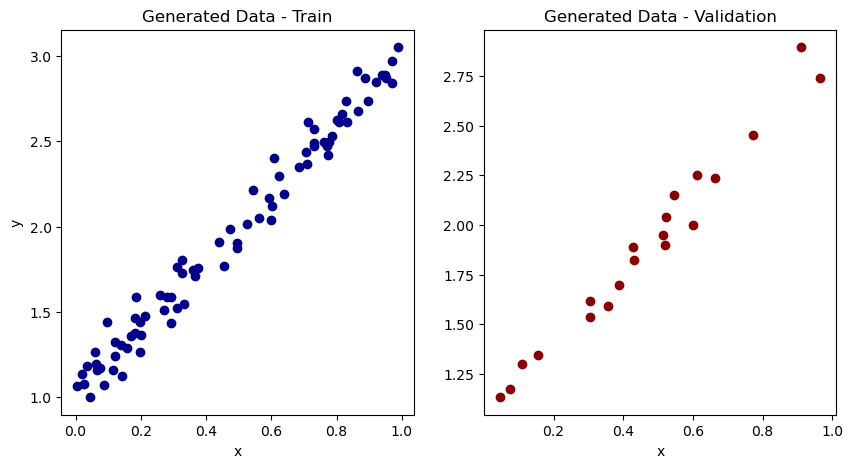

In [12]:
## Below shows a plot of the two sets of data.

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].scatter(x_train, y_train, c = 'darkblue')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('Generated Data - Train')
axes[1].scatter(x_val, y_val, c = 'darkred')
axes[1].set_xlabel('x')
axes[1].set_title('Generated Data - Validation')
plt.show()

## Moving to PyTorch

We hope to fit a regression model to the above data through a neural network. We will be building this neural network in **PyTorch** in the next section.

In [13]:
### TODO: Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors. ###
x_train_tensor = torch.from_numpy(x_train)      #.to(device) if GPU.
y_train_tensor = torch.from_numpy(y_train)

In [14]:
# Here we can see the difference - notice that .type() is more useful
# since it also tells us WHERE the tensor is (device)
print(type(x_train), type(x_train_tensor), x_train_tensor.type())

<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.DoubleTensor


## Parameter Estimation via Gradient Descent

We know that the true $a = 1$ and $b = 2$, but now let’s see how close we can get to the true values by using **gradient descent** and the 80 points in the training set.

Note: if we use all data points $\{(y_i, x_i)\}_{i=1}^N$ in the training set to compute the loss, we are performing a **batch gradient descent**. If we were to use a single, randomly picked point $(y_i, x_i)$ at each time, it would be a **stochastic gradient descent**. Anything else in-between characterizes a **mini-batch gradient descent**.

### Initialize Parameters and Require Gradients

In [15]:
# Initializes parameters "a" and "b" randomly, ALMOST as we did in Numpy
# since we want to apply gradient descent on these parameters, we need
# to set REQUIRES_GRAD = TRUE

### TODO: Initialize parameters... ###
a = torch.randn(1, requires_grad=True)      # device = device if there's need to note
b = torch.randn(1, requires_grad=True)
### ---------------------- ###

print(a, b)

tensor([-1.5134], requires_grad=True) tensor([-0.5283], requires_grad=True)


### Gradient Computation with **Autograd**

Autograd is PyTorch’s automatic differentiation package, which refrains us from manually computing all the gradients.

- The backward() method helps us to compute partial derivatives of the loss function w.r.t. our parameters.
- We obtain the computed gradients via the .grad attribute.

In [16]:
# Specifying a learning rate
lr = 1e-1

### TODO: implement the following... ###
yhat = a + b * x_train_tensor
error = y_train_tensor - yhat
loss = (error ** 2).mean()
### ---------------------- ###

# We just tell PyTorch to work its way BACKWARDS from the specified loss!
loss.backward()
# Let's check the computed gradients...
print(a.grad)
print(b.grad)

tensor([-7.4337])
tensor([-3.9805])


To update the parameters, we need to use torch.no_grad() to perform regular Python operations on tensors, independent of PyTorch’s computation graph. 

After updating, we need to clear the gradients calculated in this past step to avoid them from accumulating via the zero_() method.

In [10]:
### TODO: update the parameters ###
with torch.no_grad():       # Note briefly how this works.
    a -= lr * a.grad
    b -= lr * b.grad
### ---------------------- ###

### TODO: PyTorch is "clingy" to its computed gradients, we need to tell it to let it go... ###
a.grad.zero_()      # note the "_" which means "in-place"
b.grad.zero_()
### ---------------------- ###

tensor([0.])

Putting everything together,

In [11]:
n_epochs = 1000

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()

    # No more manual computation of gradients! 
    # a_grad = -2 * error.mean()
    # b_grad = -2 * (x_tensor * error).mean()

    ### TODO: We just tell PyTorch to work its way BACKWARDS from the specified loss! ###
    loss.backward()            
    ### ---------------------- ###

    # Let's check the computed gradients...
    if epoch % 100 == 0:
        print(a.grad)
        print(b.grad)
    
    # Updating the parameters
    ### TODO: Updating the parameters ###
    with torch.no_grad():
        a -= lr * a.grad
        b -= lr * b.grad
    
    a.grad.zero_()
    b.grad.zero_()
    ### ---------------------- ###
    
print(a, b)

tensor([-0.8781])
tensor([-0.8820])
tensor([0.0383])
tensor([-0.0750])
tensor([0.0084])
tensor([-0.0164])
tensor([0.0018])
tensor([-0.0036])
tensor([0.0004])
tensor([-0.0008])
tensor([8.6969e-05])
tensor([-0.0002])
tensor([1.9059e-05])
tensor([-3.6987e-05])
tensor([4.2216e-06])
tensor([-8.0911e-06])
tensor([9.6973e-07])
tensor([-1.8024e-06])
tensor([5.4949e-07])
tensor([-5.7005e-07])
tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


### Update All Parameters Simultaneously with **Optimizer**

Previously, we’ve been manually updating the parameters using the computed gradients. That’s probably fine for two parameters… but what if we had a whole lot of them?! We use one of PyTorch’s optimizers, like SGD or Adam.

An optimizer takes the parameters we want to update, the learning rate we want to use (and possibly many other hyper-parameters as well!) and performs the updates through its step() method.

Besides, we also don’t need to zero the gradients one by one anymore. We just invoke the optimizer’s zero_grad() method and that’s it!

In the code below, we create a Stochastic Gradient Descent (SGD) optimizer to update our parameters a and b.

In [12]:
a = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)
print("Initializations: a = {}, b = {}".format(a, b))

lr = 1e-1
n_epochs = 1000

### TODO: Defines a SGD optimizer to update the parameters ###
optimizer = optim.SGD([a, b], lr=lr)
### ---------------------- ###

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()

    loss.backward()    
    
    # No more manual update!
    # with torch.no_grad():
    #     a -= lr * a.grad
    #     b -= lr * b.grad

    ### TODO: perform the update via step() ###
    optimizer.step()
    ### ---------------------- ###
    
    # No more telling PyTorch to let gradients go!
    # a.grad.zero_()
    # b.grad.zero_()

    ### TODO: clearing the gradient ###
    optimizer.zero_grad()
    ### ---------------------- ###
    
print("Output: a = {}, b = {}".format(a, b))

Initializations: a = tensor([-0.8814], requires_grad=True), b = tensor([1.1271], requires_grad=True)
Output: a = tensor([1.0235], requires_grad=True), b = tensor([1.9690], requires_grad=True)


### Loss Computation

Once again, PyTorch get us covered for loss functions, and we don't have to manually write out the expressions. There are many loss functions to choose from, depending on the task at hand. Since ours is a regression, we are using the Mean Square Error (MSE) loss.

In [13]:
a = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)
print("Initializations: a = {}, b = {}".format(a, b))

lr = 1e-1
n_epochs = 1000

### TODO: Defines a MSE loss function ###
loss_fn = nn.MSELoss(reduction='mean')
### ---------------------- ###

optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    
    # No more manual loss!
    # error = y_tensor - yhat
    # loss = (error ** 2).mean()

    ### TODO: Incorporate loss function ###
    loss = loss_fn(y_train_tensor, yhat)
    ### ---------------------- ###

    loss.backward()    
    
    optimizer.step()
    optimizer.zero_grad()
    
print("Output: a = {}, b = {}".format(a, b))

Initializations: a = tensor([-0.6824], requires_grad=True), b = tensor([-0.5733], requires_grad=True)
Output: a = tensor([1.0235], requires_grad=True), b = tensor([1.9690], requires_grad=True)


## Model Building

In PyTorch, a model is represented by a regular Python class that inherits from the Module class.

The most fundamental methods it needs to implement are:

- \_\_init\_\_(self): it defines the parts that make up the model —in our case, two parameters, $a$ and $b$.
- forward(self, x): it performs the actual computation, that is, it outputs a prediction, given the input $x$.

Let’s build a proper (yet simple) model for our regression task. It should look like this:

In [14]:
### TODO: Define the following class ###
class ManualLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()              # inherits from nn.Module
        # Initialization of a and b.
        # To make "a" and "b" real parameters of the model, we need to wrap them with nn.Parameter
        self.a = nn.Parameter(torch.randn(1, requires_grad=True))
        self.b = nn.Parameter(torch.randn(1, requires_grad=True))
        
    def forward(self, x):
        # Computes the outputs / predictions
        return self.a + self.b * x
### ---------------------- ###

By wrapping our parameters as nn.Parameter objects, we can use our model’s parameters() method to retrieve an iterator over all model’s parameters, even those parameters of nested models, that we can use to feed our optimizer (instead of building a list of parameters ourselves!).

Moreover, we can get the current values for all parameters using our model’s state_dict() method.

Now, putting these methods all together, we can re-write our code as the following: 

In [38]:
# Now we can create a model and send it at once to the device
model = ManualLinearRegression()
# We can also inspect its parameters using its state_dict
print(model.state_dict())

lr = 1e-1
n_epochs = 1000

loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    # In PyTorch, models have a train() method which, somewhat disappointingly, 
    # does NOT perform a training step. Its only purpose is to set the model to training mode.
    
    ### TODO: enter training mode ###
    model.train()
    ### ---------------------- ###

    # No more manual prediction!
    # yhat = a + b * x_tensor

    ### TODO: auto prediction ###
    yhat = model(x_train_tensor)
    ### ---------------------- ###
    
    loss = loss_fn(y_train_tensor, yhat)
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    
print(model.state_dict())

OrderedDict([('a', tensor([-0.2573])), ('b', tensor([1.4762]))])
OrderedDict([('a', tensor([1.0235])), ('b', tensor([1.9690]))])


### **Making the Training Step More Generic (Optional)

So far, we’ve defined an **optimizer**, a **loss function** and a **model**. We now want to generalize these processes as a **training step**, so that the code could be more organized when training on batches.

We write a function that takes those three elements and returns another function that performs a training step, taking a set of features and labels as arguments and returning the corresponding loss. Then, we can use this general-purpose function to build a train_step() function to be called inside our training loop. 

Now our code should look like this… see how tiny the training loop is now?

In [ ]:
### TODO: implement the following function to generalize training step. ###
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step
### ---------------------- ###

In [39]:
# Creates the train_step function for our model, loss function and optimizer
train_step = make_train_step(model, loss_fn, optimizer)
losses = []

# For each epoch...
for epoch in range(n_epochs):
    # Performs one train step and returns the corresponding loss
    loss = train_step(x_train_tensor, y_train_tensor)
    losses.append(loss)
    
# Checks model's parameters
print(model.state_dict())

OrderedDict([('a', tensor([1.0235])), ('b', tensor([1.9690]))])


### Utilizing Package-Defined Layers

For simple tasks like building a linear regression, we could directly utilize the basic building blocks defined in the package's torch.nn module. 

In our previous model, we manually created two parameters to perform a linear regression. Let’s use PyTorch’s Linear model as an attribute of our own, thus creating a nested model. 

To do so, we could simply just replace the parameters with nn.Linear(input, output).

In [29]:
class NestedLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        ### TODO: Instead of our custom parameters, we use a Linear layer with single input and single output ###
        self.linear = nn.Linear(1, 1)
        ### ---------------------- ###
                
    def forward(self, x):
        ### TODO: Now it only takes a call to the layer to make predictions ###
        return self.linear(x)
        ### ---------------------- ###

Now, if we call the parameters() method of this model, PyTorch will figure the parameters of its attributes in a recursive way.

In [30]:
for name, param in NestedLinearRegression().named_parameters():
    if param.requires_grad:
        print(name, param.data)

linear.weight tensor([[-0.0493]])
linear.bias tensor([-0.9734])


Alternatively, if we don't even want to create a class for this simple task, we could also just use nn.Sequential.

In [40]:
### TODO: define with nn.Sequential ###
seqmodel = nn.Sequential(nn.Linear(1, 1))

In [41]:
for name, param in seqmodel.named_parameters():
    if param.requires_grad:
        print(name, param.data)

0.weight tensor([[0.9826]])
0.bias tensor([0.2325])


### Models With Hidden Layers

![One Layer Neural Network](one-layer-nn.png)

Remember the XOR-problem in lecture 2? Now, does the code in the class notes make more sense to you?

The below builds a feedforward neural network with 1 layer.

In [5]:
## one hidden layer neural net
class HiddenLayerLinearRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()

        ### TODO: Write a sequential model with one hidden layer ###
        self.sequential = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
            )
        ### ---------------------- ###

    def forward(self, x):
        y = self.sequential(x)
        return y

    # You could also define the loss function inside the model.    
    # def loss_fn(self, y, y_pred):
    #     output = nn.MSELoss(reduction='mean')(y,y_pred)
    #     return output


In [6]:
net_modlist = HiddenLayerLinearRegression(1,2)
for param in net_modlist.parameters():
    print(type(param.data), param.size())

<class 'torch.Tensor'> torch.Size([2, 1])
<class 'torch.Tensor'> torch.Size([2])
<class 'torch.Tensor'> torch.Size([1, 2])
<class 'torch.Tensor'> torch.Size([1])


In [3]:
import torch.nn.functional as F
## one hidden layer neural net
class HiddenLayerLR(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

    def forward(self, x):
        y = F.relu(nn.Linear(self.hidden_dim,1)(F.relu(nn.Linear(self.input_dim, self.hidden_dim)(x))))
        return y

In [4]:
net_modlist = HiddenLayerLR(1,2)
for param in net_modlist.parameters():
    print(type(param.data), param.size())

In the graph above, we have a 2-dimensional input, a 2-dimensional hidden layer and a 1-dimensional of output. How many parameters would we end up having?

In [43]:
for name, param in HiddenLayerLinearRegression(2,2).named_parameters():
    if param.requires_grad:
        print(name, param.data)

sequential.0.weight tensor([[-0.1374, -0.0386],
        [-0.0058, -0.0886]])
sequential.0.bias tensor([-0.1542,  0.3182])
sequential.2.weight tensor([[-0.0983,  0.4479]])
sequential.2.bias tensor([0.1999])


### Storing the Data in Datasets

Until now, we have used the whole training data at every training step. It has been batch gradient descent all along. This is fine for our ridiculously small data, sure, but for much larger data, we must use mini-batch gradient descent. Thus, we need mini-batches. Thus, we need to slice our data accordingly. 

To do so, we first introduce the Dataset class, where we can store our features and labels. We can either use a preset TensorDataset class, or build our own customized Dataset.

In [44]:
from torch.utils.data import Dataset, TensorDataset

### TODO: wrap our data in the preset TensorDataset class ###
train_data = TensorDataset(x_train_tensor, y_train_tensor)
### ---------------------- ###

print(train_data[0])

(tensor([0.7713], dtype=torch.float64), tensor([2.4745], dtype=torch.float64))


### Dataloader 

Now we introduce how we build mini-batches for batch gradient descent with PyTorch’s DataLoader class. We tell it which dataset to use (the one we just built in the previous section), the desired mini-batch size and if we’d like to shuffle it or not. That’s it!

Our loader will behave like an iterator, so we can loop over it and fetch a different mini-batch every time.

In [45]:
from torch.utils.data import DataLoader

### TODO: Load our dataset into Dataloader for batch calculations ###
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
### ---------------------- ###

To retrieve a sample mini-batch, the following will return a list containing two tensors: one for the features, another one for the labels.

In [46]:
next(iter(train_loader))

[tensor([[0.9507],
         [0.7852],
         [0.1409],
         [0.1560],
         [0.8324],
         [0.6842],
         [0.5248],
         [0.9869],
         [0.7722],
         [0.6075],
         [0.5979],
         [0.1220],
         [0.9696],
         [0.1960],
         [0.6376],
         [0.3585]], dtype=torch.float64),
 tensor([[2.8715],
         [2.5283],
         [1.1211],
         [1.2901],
         [2.6119],
         [2.3492],
         [2.0167],
         [3.0520],
         [2.4208],
         [2.4037],
         [2.0407],
         [1.2406],
         [2.8401],
         [1.4393],
         [2.1930],
         [1.7462]], dtype=torch.float64)]

Putting this into our training loop yields:

In [47]:
losses = []
train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(n_epochs):

    ### TODO: Iterate train step and append loss over batches ###
    for x_batch, y_batch in train_loader:
        
        # send to device if needed
        
        loss = train_step(x_batch, y_batch)
        losses.append(loss)
    ### ---------------------- ### 

print(model.state_dict())

OrderedDict([('a', tensor([1.0260])), ('b', tensor([1.9699]))])


### Easier Train-Validation Split via random_split()

The Dataset class also allows us to do the train-validation split in a quicker way. To do so, we just need to call random_split() on the whole Dataset object and specify the proportions.

In [48]:
from torch.utils.data.dataset import random_split

x_tensor = torch.from_numpy(x)
y_tensor = torch.from_numpy(y)

dataset = TensorDataset(x_tensor, y_tensor)

### TODO: train-val split with random_split on the whole dataset ###
train_dataset, val_dataset = random_split(dataset, [80, 20])

train_loader = DataLoader(dataset=train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=20)
### ---------------------- ###

### Evaluation

This is the last part of our journey — we need to change the training loop to include the evaluation of our model, that is, computing the validation loss. 

- Step 1: Include another inner loop to handle the mini-batches that come from the validation loader, sending them to the same device as our model. 
- Step 2: Make predictions using our model and compute the corresponding loss.

In [49]:
losses = []
val_losses = []                                                
train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:
        # send to device if needed
        loss = train_step(x_batch, y_batch)
        losses.append(loss)

    ### TODO: perform validation ###      
    with torch.no_grad():
        for x_val, y_val in val_loader:
            # send to device if needed
            model.eval()

            yhat = model(x_val)
            val_loss = loss_fn(y_val, yhat)
            val_losses.append(val_loss.item())
    ### ---------------------- ###
    

print(model.state_dict())

OrderedDict([('a', tensor([1.0328])), ('b', tensor([1.9385]))])


Two small important things to note:

- torch.no_grad(): even though it won’t make a difference in our simple model, it is a good practice to wrap the validation inner loop with this context manager to disable any gradient calculation that you may inadvertently trigger — gradients belong in training, not in validation steps;
- eval(): the only thing it does is setting the model to evaluation mode (just like its train() counterpart did), so the model can adjust its behavior regarding some operations, like Dropout.

Further optimizations: using a learning rate scheduler, etc.